In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/agriculture-crop-images/Crop_details.csv
/kaggle/input/agriculture-crop-images/test_crop_image/maize000.jfif
/kaggle/input/agriculture-crop-images/test_crop_image/rice-5174887_1280.jpg
/kaggle/input/agriculture-crop-images/test_crop_image/juteplants.jpg
/kaggle/input/agriculture-crop-images/test_crop_image/maize images.jfif
/kaggle/input/agriculture-crop-images/test_crop_image/sugarcaneplant.jpg
/kaggle/input/agriculture-crop-images/test_crop_image/maize corn set2.jpg
/kaggle/input/agriculture-crop-images/test_crop_image/wheat-field-artificial-irrigation-rural-electrification-to-harvest-166395991.jpg
/kaggle/input/agriculture-crop-images/test_crop_image/juteimg.jpg
/kaggle/input/agriculture-crop-images/test_crop_image/wheatcropfield04.jpg
/kaggle/input/agriculture-crop-images/test_crop_image/rice-4967164_1280.jpg
/kaggle/input/agriculture-crop-images/test_crop_image/rice-fields-204128_1280.jpg
/kaggle/input/agriculture-crop-images/test_crop_image/jute002.jpg
/kaggle/input

# 1. Import Packages 

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import cv2
import re
import random
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG19

In [3]:
base_dir = '/kaggle/input/agriculture-crop-images/kag2'
os.chdir(base_dir)
print(os.getcwd())

/kaggle/input/agriculture-crop-images/kag2


## 2. Data Preprocessing(

In [ ]:
def visualize_crops(base_dir, crop_names, figsize=(20, 3)):
    plt.figure(figsize=figsize)
    for idx, crop in enumerate(crop_names): 
        # loading first file from the base_dir
        crop_dir = os.path.join(base_dir, crop)
        try: 
            # read first image
            first_image = sorted(os.listdir(crop_dir))[0]
            image_path = os.path.join(crop_dir, first_image)
            image = plt.imread(image_path)

            # Visualization of first image
            plt.subplot(1, len(crop_names), idx + 1)
            plt.imshow(image)
            plt.title(crop)
            plt.axis('off')
        except Exception as e:  # 예외 처리 추가
            print(f"Error loading image for {crop}: {e}")
            plt.subplot(1, len(crop_names), idx + 1)
            plt.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
            plt.title(crop)
            plt.axis('off')
    plt.show()
            
base_dir = '/kaggle/input/agriculture-crop-images/kag2'
crop_names = ['wheat', 'jute', 'sugarcane', 'rice', 'maize']
visualize_crops(base_dir, crop_names)


In [ ]:
def count_images_per_label(base_dir, crop_names):
    label_counts = {} #create an empty list to 
    
    for crop in crop_names:
        crop_dir = os.path.join(base_dir, crop)
        try:
            # Count the number of files in the directory
            image_count = len(os.listdir(crop_dir)) #Used to list the files in each crop's directory.
            label_counts[crop] = image_count
        except Exception as e:
            print(f"Error counting images for {crop}: {e}")
            label_counts[crop] = 0  # Assign 0 if there's an error
    
    return label_counts
label_counts = count_images_per_label(base_dir, crop_names)

print("Number of Images Per Label:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

In [6]:
def augment_images(base_dir, crop_names, output_dir, augment_count=100):
   
    # ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    
    for crop in crop_names:
        crop_dir = os.path.join(base_dir, crop)
        output_crop_dir = os.path.join(output_dir, crop)
        os.makedirs(output_crop_dir, exist_ok=True)
        
        try:
            for file_name in os.listdir(crop_dir):
                file_path = os.path.join(crop_dir, file_name)
                image = tf.keras.preprocessing.image.load_img(file_path)
                image_array = tf.keras.preprocessing.image.img_to_array(image)
                image_array = image_array.reshape((1,) + image_array.shape)
                
                # Generate and save augmented images
                counter = 0
                for batch in datagen.flow(image_array, batch_size=1, save_to_dir=output_crop_dir, save_prefix=crop, save_format="jpeg"):
                    counter += 1
                    if counter >= augment_count:
                        break
        except Exception as e:
            print(f"Error processing {crop}: {e}")

# Usage
output_dir = '/kaggle/working/augmented_images'
augment_images(base_dir, crop_names, output_dir, augment_count=5)


In [7]:
def load_data(base_dir, crop_names, img_size=(128, 128)):
    images = []
    labels = []
    
    for idx, crop in enumerate(crop_names):
        crop_dir = os.path.join(base_dir, crop)
        for file_name in os.listdir(crop_dir):
            file_path = os.path.join(crop_dir, file_name)
            try:
                # Load and resize image
                img = tf.keras.preprocessing.image.load_img(file_path, target_size=img_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(idx)  # Label as the index of crop_names
            except Exception as e:
                print(f"Error loading {file_name}: {e}")
    
    return np.array(images), np.array(labels)

In [8]:
original_images, original_labels = load_data(base_dir, crop_names)
augmented_images, augmented_labels = load_data(output_dir, crop_names)

# 두 데이터를 결합
combined_images = np.concatenate((original_images, augmented_images), axis=0)
combined_labels = np.concatenate((original_labels, augmented_labels), axis=0)

# 데이터 정규화 (Normalization)
images = combined_images / 255.0  # Scale pixel values to [0, 1]

# 원핫 인코딩 (One-Hot Encoding)
labels = to_categorical(combined_labels, num_classes=len(crop_names))

# 데이터 분할 (Train/Test Split)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 학습/검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 데이터 확인
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (2985, 128, 128, 3), (2985, 5)
Validation set: (747, 128, 128, 3), (747, 5)
Test set: (933, 128, 128, 3), (933, 5)


In [9]:
# 모든 이미지를 (224, 224)로 크기 조정
X_train_resized = tf.image.resize(X_train, [224, 224])
X_val_resized = tf.image.resize(X_val, [224, 224])
X_test_resized = tf.image.resize(X_test, [224, 224])

# 크기 확인
print(f"Resized Train set: {X_train_resized.shape}")
print(f"Resized Validation set: {X_val_resized.shape}")
print(f"Resized Test set: {X_test_resized.shape}")

Resized Train set: (2985, 224, 224, 3)
Resized Validation set: (747, 224, 224, 3)
Resized Test set: (933, 224, 224, 3)


## 3. Model Training 

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

In [22]:
!pip install optuna

In [30]:
def objective(trial):
    # Define hyperparameters to optimize
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.2, 0.5)
    dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.2, 0.5)
    dense_units_1 = trial.suggest_int('dense_units_1', 128, 512, step=64)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    
    # Build the model
    vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg_base.trainable = False  # 사전 학습된 가중치 고정
    
    model = Sequential([
        vgg_base,
        GlobalAveragePooling2D(),
        Dense(dense_units_1, activation='tanh'),
        Dropout(dropout_rate_1),
        Dense(256, activation='tanh'),
        Dropout(dropout_rate_2),
        Dense(5, activation='softmax')  # 클래스 개수에 따라 조정
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        X_train_resized, y_train,
        validation_data=(X_val_resized, y_val),
        epochs=10,  # 빠른 테스트를 위해 10 에포크 사용
        batch_size=32,
        verbose=0
    )
    
    # Return validation accuracy
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy


In [31]:
import optuna

# Create Optuna study
study = optuna.create_study(direction='maximize')  # Validation accuracy를 최대화
study.optimize(objective, n_trials=20)  # 20번의 시도

# Best hyperparameters 출력
print("Best hyperparameters:", study.best_params)

[I 2025-01-24 22:35:15,686] A new study created in memory with name: no-name-5e4d2e69-806f-4ee5-866c-b4c78dca593a
[I 2025-01-24 22:36:52,768] Trial 0 finished with value: 0.6653279662132263 and parameters: {'dropout_rate_1': 0.49287108384542705, 'dropout_rate_2': 0.4811991047397984, 'dense_units_1': 128, 'learning_rate': 0.00017847471306300808}. Best is trial 0 with value: 0.6653279662132263.
[I 2025-01-24 22:38:30,035] Trial 1 finished with value: 0.6907630562782288 and parameters: {'dropout_rate_1': 0.29649603559780396, 'dropout_rate_2': 0.4632185142610278, 'dense_units_1': 320, 'learning_rate': 0.00012171776896897454}. Best is trial 1 with value: 0.6907630562782288.
[I 2025-01-24 22:40:06,895] Trial 2 finished with value: 0.5809906125068665 and parameters: {'dropout_rate_1': 0.27681047893712535, 'dropout_rate_2': 0.29641563349428623, 'dense_units_1': 512, 'learning_rate': 4.2491196882138695e-05}. Best is trial 1 with value: 0.6907630562782288.
[I 2025-01-24 22:41:43,156] Trial 3 fin

Best hyperparameters: {'dropout_rate_1': 0.3775721354813533, 'dropout_rate_2': 0.20764278087842378, 'dense_units_1': 192, 'learning_rate': 0.0009709156003144399}


In [32]:
best_params = {
    'dropout_rate_1': 0.3775721354813533,
    'dropout_rate_2': 0.20764278087842378,
    'dense_units_1': 192,
    'learning_rate': 0.0009709156003144399
}

# VGG19 모델 구성
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = False  # 사전 학습된 가중치 고정

vgg_model = Sequential([
    vgg_base,
    GlobalAveragePooling2D(),
    Dense(best_params['dense_units_1'], activation='relu'),
    Dropout(best_params['dropout_rate_1']),
    Dense(256, activation='relu'),  # 256은 고정값으로 사용
    Dropout(best_params['dropout_rate_2']),
    Dense(5, activation='softmax')  # 클래스 개수에 따라 수정
])

# 모델 컴파일
vgg_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 요약 출력
vgg_model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_21          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 192)                 │          98,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 256)                 │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,173,573 (76.96 MB)

 Trainable params: 149,189 (582.77 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [33]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # val_loss가 5번 연속 개선되지 않으면 중단
    restore_best_weights=True
)

# 모델 학습
history = vgg_model.fit(
    X_train_resized, y_train,
    validation_data=(X_val_resized, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.2341 - loss: 1.6277 - val_accuracy: 0.4859 - val_loss: 1.3395
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.4431 - loss: 1.3295 - val_accuracy: 0.5462 - val_loss: 1.0783
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.5703 - loss: 1.0763 - val_accuracy: 0.6345 - val_loss: 0.9549
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.6229 - loss: 0.9759 - val_accuracy: 0.6586 - val_loss: 0.8901
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.6455 - loss: 0.8946 - val_accuracy: 0.7149 - val_loss: 0.7783
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.6967 - loss: 0.7869 - val_accuracy: 0.6720 - val_loss: 0.8325
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.7218 - loss: 0.7280 - val_accuracy: 0.8072 - val_loss: 0.5827
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.7509 - loss: 0.6288 - val_accuracy: 0.

In [35]:
# VGG19 상위 레이어 학습 가능 설정
vgg_base.trainable = True
for layer in vgg_base.layers[:-4]:  # 마지막 4개 레이어 제외하고 고정
    layer.trainable = False

# 재컴파일
vgg_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate'] * 0.1),  # 학습률 감소
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 재학습
history = vgg_model.fit(
    X_train_resized, y_train,
    validation_data=(X_val_resized, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.6958 - loss: 1.3362 - val_accuracy: 0.9237 - val_loss: 0.2116
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9291 - loss: 0.2020 - val_accuracy: 0.8367 - val_loss: 0.3972
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9132 - loss: 0.2476 - val_accuracy: 0.9572 - val_loss: 0.0985
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9664 - loss: 0.1033 - val_accuracy: 0.9866 - val_loss: 0.0392
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9870 - loss: 0.0418 - val_accuracy: 0.9786 - val_loss: 0.0652
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9676 - loss: 0.1282 - val_accuracy: 0.9545 - val_loss: 0.1553
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9703 - loss: 0.0863 - val_accuracy: 0.9746 - val_loss: 0.1004
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9870 - loss: 0.0379 - val_accu

In [38]:
# 재학습 후 테스트 데이터 평가
test_loss, test_accuracy = vgg_model.evaluate(X_test_resized, y_test, verbose=0)
print(f"Test Accuracy after Fine-Tuning: {test_accuracy * 100:.2f}%")


Test Accuracy after Fine-Tuning: 99.36%


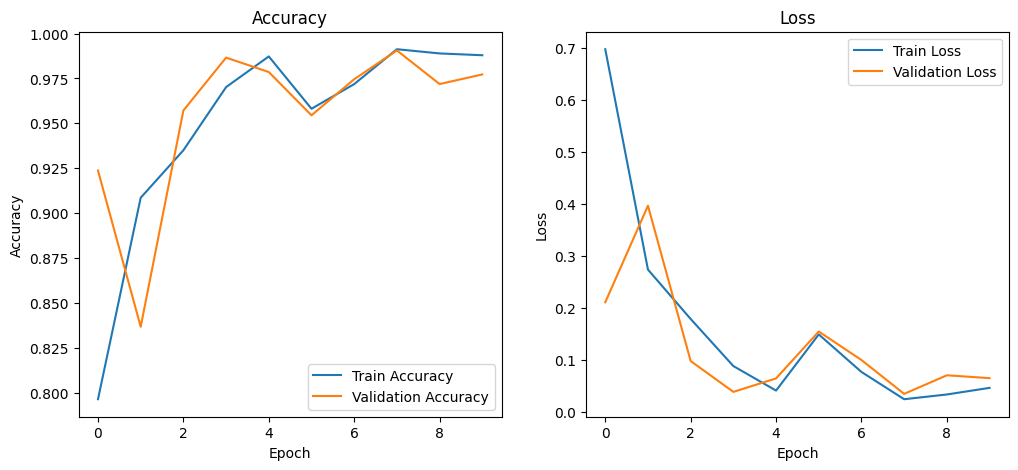

In [41]:
# 학습 및 검증 결과 시각화
plt.figure(figsize=(12, 5))

# 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# 손실
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
Confusion Matrix:
[[199   0   1   1   0]
 [  0 178   0   0   0]
 [  0   0 174   0   0]
 [  0   0   1 192   0]
 [  0   2   1   0 184]]


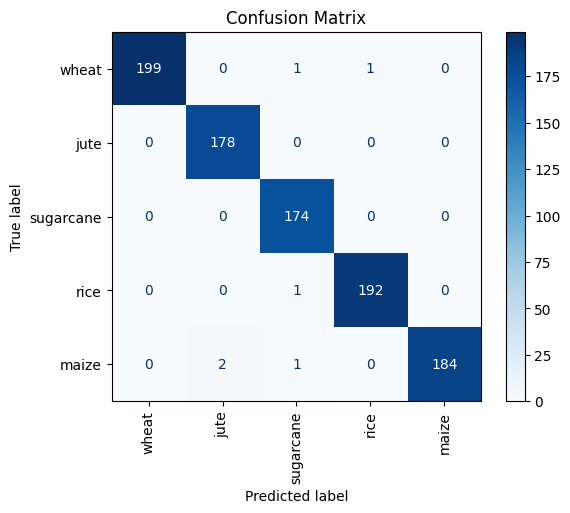

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 테스트 데이터 예측
y_pred_probs = vgg_model.predict(X_test_resized)  # 예측 확률 값 반환
y_pred = np.argmax(y_pred_probs, axis=1)  # 예측 확률을 클래스 인덱스로 변환
y_true = np.argmax(y_test, axis=1)  # 실제 레이블(One-hot Encoding → 인덱스)

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=crop_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()